<a href="https://colab.research.google.com/github/Shimoka-sempai/DS/blob/main/%D0%A2%D0%B8%D1%82%D0%B0%D0%BD%D0%B8%D0%BA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
df = pd.read_csv('train.csv')

In [36]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [37]:
df.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


Логически посмотрим на данные.
1) Embarked - обозначает город посадки на борт. Не может иметь последовательной корреляции с виживаемостью на больших данных.
2) Cabin - слишком много незаполненных ячеек, попытка заполнения не может быть успешной из-за маленького объема данных
3) PassangerID - просто цифра
4) Name - имя. Является уникальным для каждого пассажира, поэтому не может иметь логическую корреляцию с целью задачи.
5) Ticket. Единственное, что эта информация может дать при очень аккуратной и сложной технически разметке - город, где покупался билет. И то это будет примерная оценка.


In [38]:
df = df.drop('Embarked', axis=1)
df = df.drop('Cabin', axis=1)
df = df.drop('PassengerId', axis=1)
df = df.drop('Name', axis=1)
df = df.drop('Ticket', axis=1)

In [39]:
df.isnull().sum()

,0
Survived,0
Pclass,0
Sex,0
Age,177
SibSp,0
Parch,0
Fare,0


In [40]:
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

In [41]:
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,0,22.0,1,0,7.2500
1,1,1,1,38.0,1,0,71.2833
2,1,3,1,26.0,0,0,7.9250
3,1,1,1,35.0,1,0,53.1000
4,0,3,0,35.0,0,0,8.0500
...,...,...,...,...,...,...,...
886,0,2,0,27.0,0,0,13.0000
887,1,1,1,19.0,0,0,30.0000
888,0,3,1,NaN,1,2,23.4500
889,1,1,0,26.0,0,0,30.0000


Главная проблема двух графиков ниже - их интерпретация. Параментр является гибридным, поэтому, например, 1 колонке SibSp может обозначать как супруга, так и брата/сестру. Аналогичная проблема присутствует и в колонке Parch. Еще больше усложняет ситуацию то, что на титанике может быть три поколения одной семьи, или, например, дедушка с внуком, что не будет как либо зачислено в датасете. Поэтому эти колонки отбрасываются для подсчета корреляции возраста.

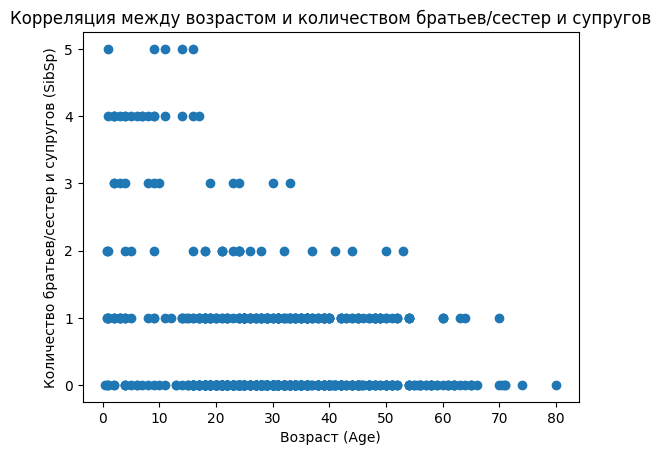

In [42]:
plt.scatter(df['Age'], df['SibSp'])
plt.xlabel('Возраст (Age)')
plt.ylabel('Количество братьев/сестер и супругов (SibSp)')
plt.title('Корреляция между возрастом и количеством братьев/сестер и супругов')
plt.show()

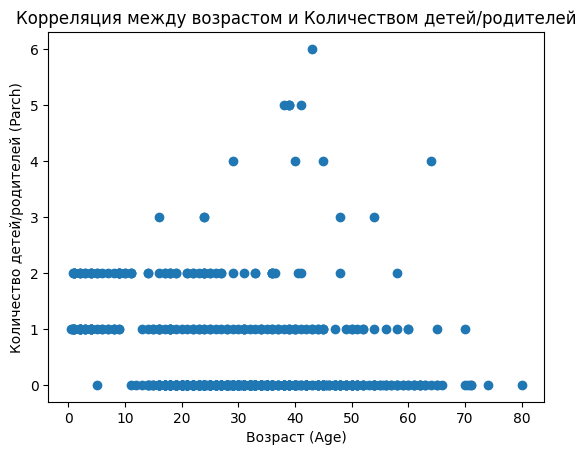

In [43]:
plt.scatter(df['Age'], df['Parch'])
plt.xlabel('Возраст (Age)')
plt.ylabel('Количество детей/родителей (Parch)')
plt.title('Корреляция между возрастом и Количеством детей/родителей')
plt.show()

Есть группа значений с увеличенной ценой билета возрастом от 15 до 50

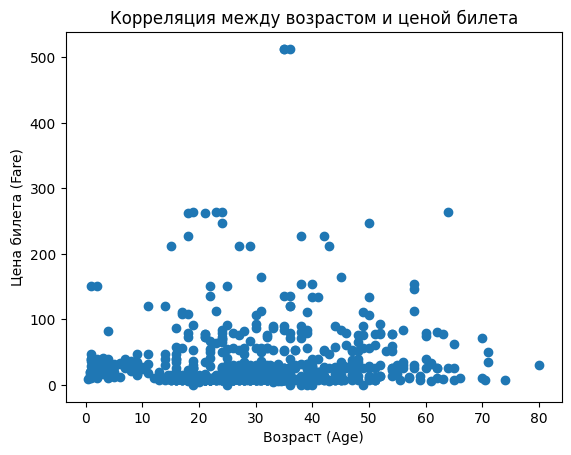

In [44]:
plt.scatter(df['Age'], df['Fare'])
plt.xlabel('Возраст (Age)')
plt.ylabel('Цена билета (Fare)')
plt.title('Корреляция между возрастом и ценой билета')
plt.show()

Мы видим яркий провал в средней возрастной группе 20 - 50 лет

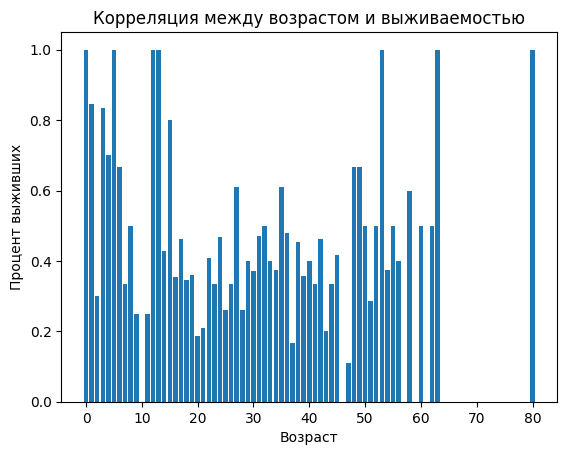

In [45]:
rounded_ages = df['Age'].round()
survival_rates = df.groupby(rounded_ages)['Survived'].mean()
plt.bar(survival_rates.index, survival_rates.values)
plt.xlabel('Возраст')
plt.ylabel('Процент выживших')
plt.title('Корреляция между возрастом и выживаемостью')
plt.show()

Мужчины среднестатистически старше, а также у них больше крайних значений

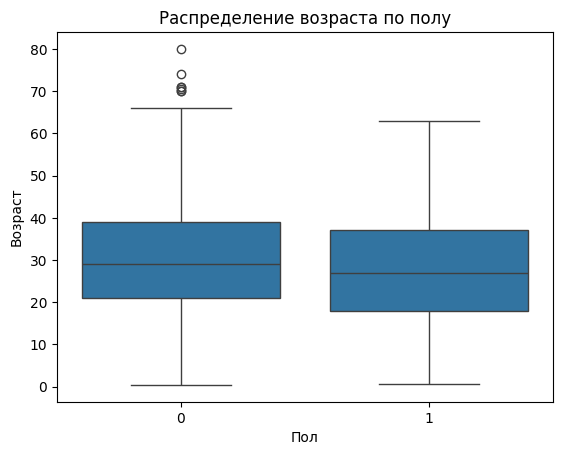

In [46]:
sns.boxplot(x='Sex', y='Age', data=df)
plt.xlabel('Пол')
plt.ylabel('Возраст')
plt.title('Распределение возраста по полу')
plt.show()

С помощью модели K ближайших соседей выстраиваем корреляцию возраста с параметрами класса билета, пола и стоимости билета и делаем предсказание для пустых ячеек.

In [47]:
df_train = df[~df['Age'].isnull()]
features = ['Pclass', 'Sex', 'Fare', 'Survived']
model =  KNeighborsRegressor(n_neighbors=5)
model.fit(df_train[features], df_train['Age'])
df_test = df[df['Age'].isnull()]
predicted_age = model.predict(df_test[features])
df.loc[df['Age'].isnull(), 'Age'] = predicted_age

In [48]:
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,0,22.0,1,0,7.2500
1,1,1,1,38.0,1,0,71.2833
2,1,3,1,26.0,0,0,7.9250
3,1,1,1,35.0,1,0,53.1000
4,0,3,0,35.0,0,0,8.0500
...,...,...,...,...,...,...,...
886,0,2,0,27.0,0,0,13.0000
887,1,1,1,19.0,0,0,30.0000
888,0,3,1,27.8,1,2,23.4500
889,1,1,0,26.0,0,0,30.0000


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int64  
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
dtypes: float64(2), int64(5)
memory usage: 48.9 KB


In [50]:
X = df.drop(columns=['Survived'])
y = df['Survived']

Присутствует дизбаланс классов

In [51]:
df['Survived'].value_counts()

,count
Survived,
0,549
1,342


По графику ниже можем заметить сильную корреляцию с колонками Fare, Pclass и сладую корреляцию с Age и Parch. Корреляция с SibSp практически отсутствует.

In [52]:
df.corr()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,0.543351,-0.111891,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,-0.131900,-0.357595,0.083081,0.018443,-0.549500
Sex,0.543351,-0.131900,1.000000,-0.132805,0.114631,0.245489,0.182333
Age,-0.111891,-0.357595,-0.132805,1.000000,-0.202555,-0.177871,0.091416
SibSp,-0.035322,0.083081,0.114631,-0.202555,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,0.245489,-0.177871,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,0.182333,0.091416,0.159651,0.216225,1.000000


In [53]:
df = df.drop('SibSp', axis=1)

In [54]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

X = df.drop('Survived', axis=1)
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)

# Простая полносвязная сеть
model1 = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Сеть с дропаутом
model2 = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Сеть с рекуррентным слоем
model3 = keras.Sequential([
    layers.LSTM(64, input_shape=(X_train.shape[1], 1)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

for model in [model1, model2, model3]:
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

epochs = 10
for model in [model1, model2, model3]:
    model.fit(
        X_train, y_train,
        epochs=epochs,
        validation_data=(X_test, y_test)
    )

for model in [model1, model2, model3]:
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    f1 = f1_score(y_test, y_pred)
    print(f'Модель {model.name}:')
    print(f'Точность: {accuracy}')
    print(f'F1-мера: {f1}')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.6384 - loss: 1.8788 - val_accuracy: 0.7239 - val_loss: 0.6823
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6722 - loss: 0.6724 - val_accuracy: 0.6194 - val_loss: 0.5874
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6690 - loss: 0.6008 - val_accuracy: 0.7537 - val_loss: 0.5464
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6762 - loss: 0.5997 - val_accuracy: 0.7537 - val_loss: 0.5471
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6782 - loss: 0.5903 - val_accuracy: 0.5821 - val_loss: 0.6459
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6525 - loss: 0.6159 - val_accuracy: 0.7239 - val_loss: 0.5340
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6776 - loss: 0.5801 - val_accuracy: 0.7313 - val_loss: 0.5286
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7064 - loss: 0.5746 - val_accuracy: 0.7090 - val_loss

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Модель sequential_2:
Точность: 0.6940298676490784
F1-мера: 0.5684210526315789


Наилучшая точность вышла у простой модели. Дальше была проведена серия экспериментов с разной топологией слоей сети и их количеством

In [56]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)

# Модель 1, 128 и 64 нейрона
model1 = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Модель 2, 64 и 128 нейронов
model2 = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Модель 3, 64, 128 и 64 нейронов
model3 = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

for model in [model1, model2, model3]:
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

epochs = 10
for model in [model1, model2, model3]:
    model.fit(
        X_train, y_train,
        epochs=epochs,
        validation_data=(X_test, y_test)
    )

for model in [model1, model2, model3]:
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    f1 = f1_score(y_test, y_pred)
    print(f'Модель {model.name}:')
    print(f'Точность: {accuracy}')
    print(f'F1-мера: {f1}')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.5643 - loss: 1.2843 - val_accuracy: 0.7164 - val_loss: 0.6586
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6851 - loss: 0.6155 - val_accuracy: 0.5821 - val_loss: 0.6035
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6808 - loss: 0.5883 - val_accuracy: 0.7164 - val_loss: 0.5470
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7139 - loss: 0.5608 - val_accuracy: 0.6045 - val_loss: 0.5939
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6745 - loss: 0.5996 - val_accuracy: 0.7239 - val_loss: 0.5317
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6914 - loss: 0.6003 - val_accuracy: 0.7090 - val_loss: 0.5335
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7260 - loss: 0.5350 - val_accuracy: 0.7463 - val_loss: 0.5234
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7518 - loss: 0.5229 - val_accuracy: 0.7687 - val_loss

Наибольшую точность показал модель с 64 и 128 нейронами. Дальше были проведены эксперименты на ее основе с изменением количества нейронов.

In [57]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)

# Модель 1, 128 и 256 нейрона
model1 = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Модель 2, 64 и 256 нейронов
model2 = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Модель 3, 128 и 512 нейронов
model3 = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

for model in [model1, model2, model3]:
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

epochs = 10
for model in [model1, model2, model3]:
    model.fit(
        X_train, y_train,
        epochs=epochs,
        validation_data=(X_test, y_test)
    )

for model in [model1, model2, model3]:
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    f1 = f1_score(y_test, y_pred)
    print(f'Модель {model.name}:')
    print(f'Точность: {accuracy}')
    print(f'F1-мера: {f1}')

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.6257 - loss: 0.8774 - val_accuracy: 0.5896 - val_loss: 0.6125
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6658 - loss: 0.6204 - val_accuracy: 0.7463 - val_loss: 0.5630
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6983 - loss: 0.6050 - val_accuracy: 0.5821 - val_loss: 0.6053
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6690 - loss: 0.5931 - val_accuracy: 0.6866 - val_loss: 0.5625
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6732 - loss: 0.6181 - val_accuracy: 0.7388 - val_loss: 0.5928
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6858 - loss: 0.6174 - val_accuracy: 0.7463 - val_loss: 0.6745
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6963 - loss: 0.7606 - val_accuracy: 0.7985 - val_loss: 0.5568
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7497 - loss: 0.5528 - val_accuracy: 0.5896 - val_loss: 0.6009
Ep

Большее кол-во нейронов на скрытом и входном слое показало наилучший результат

In [65]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

f1_scores = []
reports = []
matrices = []

for train_index, test_index in kfold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        layers.Dense(512, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    model.fit(
        X_train, y_train,
        epochs=10,
        verbose=0
    )

    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

    y_pred = (model.predict(X_test) > 0.5).astype(int)

    f1 = f1_score(y_test, y_pred)
    f1_scores.append(f1)
    report = classification_report(y_test, y_pred)
    reports.append(report)
    matrix = confusion_matrix(y_test, y_pred)
    matrices.append(matrix)

    print(f'Фолд:')
    print(f'Точность: {accuracy}')
    print(f'F1-мера: {f1}')
    print(f'Classification Report:\n{report}')
    print(f'Confusion Matrix:\n{matrix}')

print('\nСредние значения по всем фолдам:')
print(f'Средняя F1-мера: {sum(f1_scores) / len(f1_scores)}')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Фолд:
Точность: 0.7239057421684265
F1-мера: 0.5176470588235295
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.93      0.81       183
           1       0.79      0.39      0.52       114

    accuracy                           0.72       297
   macro avg       0.75      0.66      0.66       297
weighted avg       0.74      0.72      0.70       297

Confusion Matrix:
[[171  12]
 [ 70  44]]


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Фолд:
Точность: 0.7138047218322754
F1-мера: 0.6473029045643154
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.73      0.76       183
           1       0.61      0.68      0.65       114

    accuracy                           0.71       297
   macro avg       0.70      0.71      0.70       297
weighted avg       0.72      0.71      0.72       297

Confusion Matrix:
[[134  49]
 [ 36  78]]


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Фолд:
Точность: 0.6464646458625793
F1-мера: 0.1984732824427481
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.98      0.77       183
           1       0.76      0.11      0.20       114

    accuracy                           0.65       297
   macro avg       0.70      0.55      0.49       297
weighted avg       0.69      0.65      0.55       297

Confusion Matrix:
[[179   4]
 [101  13]]

Средние значения по всем фолдам:
Средняя F1-мера: 0.4544744152768643


Кросс валидация показала противоречивые результаты с точки зрения эффективности модели, на некоторых фолдах метрики были неплохими, на других они были не самыми лучшими.
1 Фолд: Модель предсказала 171 погибшего верно, отнеся 12 к неправильному классу. Также модель предсказала 70 выживших верно и отнесла 44 к неправильному классу
2 Фолд: Модель предсказала 134 погибших верно, отнеся 49 к неправильному классу. Также модель предсказала 36 выживших верно и отнесла 78 к неправильному классу
3 Фолд: Модель предсказала 179 погибших верно, отнеся 4 к неправильному классу. Также модель предсказала 101 выжившего верно и отнесла 13 к неправильному классу

Вывод: Был проделан комплексный обзор даты с дозаполнением пустых ячеек методом K ближайших соседей. Было проведено 9 экспериментов с целью найти наиболее эффективную модель. Модель, показавшая наилучший результат, была подвергнута тестированию на трех фолдах, которое показало ее уязвимость перед другими частями датасета. Главной сложностью работы я вижу маленький объем датасета, что делает любые попытки точного предсказания труднореализуемыми из-за флуктуций в дате, которые не невелируются ее объемом.